# Instalation of the package CaImAn

First, in order to work on google.colab environmnet we have to run the following code block.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mount the google drive environment to connect to the
                              # folder in google drive that stores the data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Secondly we install the package CaImAn (https://github.com/flatironinstitute/CaImAn.git) and its requeriments with the commnad pip so it could work in the Colab environment.

In [ ]:
!pip install git+https://github.com/flatironinstitute/CaImAn.git --quiet
!pip install pims --quiet
!pip install pynwb --quiet
!pip install ipyparallel --quiet
!pip install peakutils --quiet
!pip install tifffile --quite

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.3/555.3 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.9 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


Now we install the packages that made the whole software work. This code is from the code published by the developers with some modifications to make it work better.

In [ ]:
try:
    (magic_name, parameter_s).get_ipython().magic(u'load_ext autoreload')
    (magic_name, parameter_s).get_ipython().magic(u'autoreload 2')
    (magic_name, parameter_s).get_ipython().magic(u'matplotlib qt')
except:
    pass

import logging
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy
import seaborn as sns
from scipy.special import logsumexp
from skimage.restoration import denoise_wavelet
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.paths import caiman_datadir
import pandas as pd
import cv2
import io
import tifffile
import matplotlib as mpl
import matplotlib.gridspec as grid_spec
import base64
from IPython.display import HTML
import os
try:
    cv2.setNumThreads(0)
except:
    pass
import bokeh.plotting as bpl
import holoviews as hv
bpl.output_notebook()
hv.notebook_extension('bokeh')

# Mathematical analysis functions

In [ ]:

##### function that generates the amount of peaks of the signal

def generate_peaks(graph, height=0, plot=False, number=False, distance = 1 ):
  '''
  input:

  graph : nd.array
          the nd.array that stores the temporal values of the DF/F profile
  height: int
          indicates the minimal required to interpretate as a signal
  plot: bool
        Indicates whether you like to output the plot of the peaks and signal or not
  number: bool
          Indicate whether you like to output the number of peaks or not
  distance: int
            This parameters define the distance of the peaks in order to consider them as peaks.
            for example, if we consider [0,0,0,4,0,8]
            if distance is 1: 4 is considered a peak. But if distance is 2: 4 is not
            considered as a peak, because at a distance of 2 is other number higher than 4.
  output:
  n_peaks: int
           the number of peaks of the graph in the timeframe of evaluation
  '''

  peaks,_= scipy.signal.find_peaks(graph, height=height , distance = distance)
  n_peaks = len(peaks)
  if plot == True:
    plt.figure()
    plt.plot(graph)
    plt.plot(peaks, graph[peaks],"x")

  if number==True:
    print("the number of peaks is "+ str(n_peaks))
  return n_peaks


###### function that generates the seconds and images of the system
#

def seconds_images(fname):
  '''
  input:

  fname: string
         a string containing the path to the .tif file to analyze

  output:

  seconds_interval: int
                    The amount of seconds between to frames
  n_images: int
            The amoun of images in the .tif file

  seconds: int
           the length of the video in seconds


  considerations:
    for a better analysis make sure that your .tif file contains in its metadata
    the interval of seconds between each frame, or in the frames are labeled as the
    second in which it was taken. Other types of metadata cannot be analyze due to the
    lack of the temporal parameter.
  '''
  with tifffile.TiffFile(fname) as tif: # we read the tiff file of the images to extract the seconds interval
    volume = tif.asarray()
    axes = tif.series[0].axes
    imagej_metadata = tif.imagej_metadata

  keys_metadata= list(imagej_metadata.keys())

  # if the .tif file stores the amount of seconds between images
  if'finterval' in keys_metadata: # if the metadata contains the interval between the frames
    seconds_interval=imagej_metadata['finterval'] # the seconds between two frames
    n_images=imagej_metadata['images']
    return seconds_interval, n_images

  # if the .tif file stores the seconds that took to take the video as labels of the images
  else:  # if the label of the metadata frames contains the amount of seconds that took
         # to take the pictures
    labs = imagej_metadata['Labels']
    seconds = labs[-1].strip(' s')
    seconds_interval = float(labs[1].strip(' s'))-labs[0].strip(' s')
    n_images = imagej_metadata['images']
    return seconds_interval, n_images



####### this function generates the frequency of peaks of the signal

def generate_frequency(graph, sec_img,height=0, distance = 1):
  '''
  input:

  graph : nd.array
          the nd.array that stores the temporal values of the DF/F profile
  sec_img: tuple
           tuple that contains the seconds between two frames and the total images
           in the .tif file
  height: int
          indicates the minimal required to interpretate as a signal
 distance: int
           This parameters define the distance of the peaks in order to consider them as peaks.
           for example, if we consider [0,0,0,4,0,8]
           if distance is 1: 4 is considered a peak. But if distance is 2: 4 is not
           considered as a peak, because at a distance of 2 is other number higher than 4.

  output:

  frequency: int
             the frequency of the peaks
  '''
  if len(sec_img) == 2:
    duration = sec_img[0] * (sec_img[1]-1) # calculate the duration of the video
  if len(sec_img) == 1:
    duration = float(sec_img[0])
  n_peaks = generate_peaks(graph,height=height, plot=False, number=False, distance = distance)
  frequency= n_peaks/duration
  return frequency

###### this function generates the average height of the peaks in the signal expression

def generate_average_hpeak(graph, height=0, distance = 1):
  '''
  input:

  graph : nd.array
          the nd.array that stores the temporal values of the DF/F profile
  height: int
          indicates the minimal required to interpretate as a signal
  distance: int
            This parameters define the distance of the peaks in order to consider them as peaks.
            for example, if we consider [0,0,0,4,0,8]
            if distance is 1: 4 is considered a peak. But if distance is 2: 4 is not
            considered as a peak, because at a distance of 2 is other number higher than 4.

  output:

  average: int
             The average height of the calcium peaks

  '''
  peaks,properties= scipy.signal.find_peaks(graph, height=height, distance = distance)
  height_peaks = properties['peak_heights']
  average= np.mean(height_peaks)
  return average

#### this function generates the width of the half of the peak

def generate_whm(graph, sec_img,height=0,distance = 1,plot=False):
  '''
  input:

  graph : nd.array
          the nd.array that stores the temporal values of the DF/F profile
  height: int
          indicates the minimal required to interpretate as a signal
  distance: int
           This parameters define the distance of the peaks in order to consider them as peaks.
           for example, if we consider [0,0,0,4,0,8]
           if distance is 1: 4 is considered a peak. But if distance is 2: 4 is not
           considered as a peak, because at a distance of 2 is other number higher than 4.

  output:

  whm: nd.array
       indicates the whm of the peaks

  '''
  peaks,properties= scipy.signal.find_peaks(graph, height=height, distance = distance)
  width_peak=scipy.signal.peak_widths(graph, peaks,rel_height=0.5)
  if len(peaks) == 0:
    whm = [0]
  else:
    whm = width_peak[0]
  if plot==True:
    results_half = scipy.signal.peak_widths(graph, peaks, rel_height=0.5)
    plt.figure()
    plt.plot(graph)
    plt.plot(peaks, graph[peaks], "x")
    plt.hlines(*results_half[1:], color="C2")
  whm = np.array(whm) * float(sec_img[0])

  return whm
# this function generates the analysis of the fluorescent expression of the
# components of the tissue

def analyze_df_f(spatial_components,  fname, initial_idx=0, final_idx=0, idx_comp=[], height = 0, distance = 1,idx = 'all' ):
  '''
  input:

  spatial_components: nd.array
                      an nd.array which contains the graphs of the DF_F profile
  fname: string
         string containing the path to the .tif file to analyze
  initial_idx: int
               intial component of the interval to analyze. Only use if idx == 'interval'
  final_idx: int
             final component of the interval to analyze. Only use if idx == 'interval',
             containing this last one
  idx_comp: list
            list of the indexes of the components to analyze
            if you want the component number i use i as input
  height: int
          indicates the minimal required to interpretate as a signal
   distance: int
            This parameters define the distance of the peaks in order to consider them as peaks.
            for example, if we consider [0,0,0,4,0,8]
            if distance is 1: 4 is considered a peak. But if distance is 2: 4 is not
            considered as a peak, because at a distance of 2 is other number higher than 4.
  idx: string
       indicate the interval type of the components
          'all': Analize all the components
          'interval': indicate the interval of components to analyze. If this is
                      the case indicate the initial and final component index.
          'specific': indicate the specific number of the components to analyze.

  output:

  analysis: dict
            a nested dictionary that indicates the parameters of each component
            'numnumber_of_peaks': number of peaks in the time frame
            'fraquency_of_peaks': frequency of the peaks over the time
            'whm_of_peaks': whm of the peaks
            'peaks_average_height': the average height of the peaks
  '''
  analysis=dict()
  sec_image=seconds_images(fname)

  if idx == 'all':
    index = range(len(spatial_components))
  elif idx == 'interval' and (bool(initial_idx)or initial_idx==0) and bool(final_idx) :
    index = range(initial_idx, final_idx+1)
  elif idx == 'specific' and bool(idx_comp):
    index = np.array(idx_comp)-1
############## analysis loop ##############
  for i in index:

    graph=spatial_components[i]
    n_peaks=generate_peaks(graph,height=height, distance = distance)
    freq=generate_frequency(graph,sec_image,height=height, distance = distance)
    peak_whm=generate_whm(graph,sec_img = sec_image,height=height)
    peak_aver=generate_average_hpeak(graph, height = height , distance = distance)
    results={'number_of_peaks': n_peaks,
            'frequency_of_peaks': freq,
            'whm_of_peaks':peak_whm,
            'peaks_average_height':peak_aver}

    analysis[i+1]=results
  return analysis

#### this function generates the average of the parameters calculates by the
#### function analyze_df_f

def average_parameters(dict_results):
  '''
  input:

  dict_results: dict
                dictionary containing the information of each cell identified by the analysis tool.
  output:

  out: dict
       dictionary containing the information asked, it has the average resul of the
       parameters calculated by the function analyze_df_f
       outpus:
          average_number_of_peaks
          verage_frequency_of_peaks
          average_whm_of_peaks
          average_average_heigh_of_peaks
  '''
  num_peaks = 0
  freq_peaks = 0
  whm_of_peaks = 0
  hg_peaks = 0
  comps=len(dict_results)
  for i in range(len(dict_results)):
    num_peaks+=dict_results[i+1]['number_of_peaks']
    freq_peaks += dict_results[i+1]['frequency_of_peaks']
    whm_of_peaks += logsumexp(dict_results[i+1]['whm_of_peaks'])/len(dict_results[i+1]['whm_of_peaks'])


    hg_peaks += dict_results[i+1]['peaks_average_height']
  out = {'average_number_of_peaks':num_peaks/comps,
          'average_frequency_of_peaks':freq_peaks/comps,
          'average_whm_of_peaks':whm_of_peaks/comps,
          'average_average_heigh_of_peaks':hg_peaks/comps}
  return out

# Yoda1 analysis

Now we are going to analyze the expression of the calcium signal of the wing disc under Insulin. This code will generate the source extraction to indentify the cells under expression and from it will extract the DF/F (fluorescence) of the cell.

To extract the .tif file that is going to be analyzed generate the parameters that give the direction to the .tif file. This is going to passed to the software to know where is the file and then analyze it.

```fnames```: path to the file

```path_to_model```: path to the file which contains the movie


In [ ]:
fnames=['/content/drive/MyDrive/Internship/colabs/nd_files/Yoda1_1um_60x/time60min/D1/t6imelapse/d2_t60_timelapse_mcor.tif']
path_to_model='/content/drive/MyDrive/Internship/colabs/nd_files/Yoda1_1um_60x/time60min/D1/t6imelapse'

Now we generate the cluster which is going to develop the analysis. This is in order to start the parallel processing of the software.

In [ ]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

## Motion Correction

Now we generate a dictionary that will contain the parameters to generate the motion correction parameters. This parameters are explained in the following block.

In [ ]:
# dataset dependent parameters
frate = 10                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': fnames, # this is the parameter that indicates the location of the video in the computer
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan,
    'path_to_model': path_to_model # this is the parameter that indicates the location of the folder that contains the video
}

opts = params.CNMFParams(params_dict=mc_dict) # now pass the parameters to the program in this format


Now we generate the motion correction through NoRMCorre algorithm. This is generated by the following code block.

Is necessary to generate the motion correction of the video in order to avoid the error generated from the movement of the tissue.



Decode mmap filename /content/drive/MyDrive/Internship/colabs/nd_files/Yoda1_1um_60x/time60min/D1/t6imelapse/d2_t60_timelapse_mcor_rig__d1_405_d2_445_d3_1_order_F_frames_301.mmap


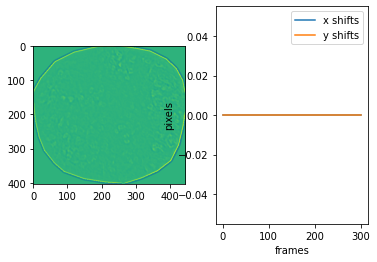

In [ ]:
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig)  # % plot template
        plt.subplot(1, 2, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')

    bord_px = 0 if border_nan == 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=dview)

Now we load the memory map

In [ ]:
# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

Decode mmap filename /content/drive/MyDrive/Internship/colabs/nd_files/Yoda1_1um_60x/time60min/D1/t6imelapse/memmap_d1_405_d2_445_d3_1_order_C_frames_301.mmap


## Source Extraction

Now we set the parameters for the source extraction algorithm CNMF-E. This parameters are going to be passed to the software by updating the variable generated before as shown in the following code block

In [ ]:


# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = (5, 5)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (13, 13)     # average diameter of a neuron, in general 4*gSig+1
Ain = None          # possibility to seed with predetermined binary masks
merge_thr = .7      # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 40    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 2            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = True  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 2             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 2        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = 0.9      # min peak value from correlation image
min_pnr = 6        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 3  # radius of ring is gSiz*ring_size_factor

opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px})                # number of pixels to not consider in the borders)



CNMFParams:

data:

{'caiman_version': '1.9.14',
 'decay_time': 0.4,
 'dims': (405, 445),
 'dxy': (1, 1),
 'fnames': ['/content/drive/MyDrive/Internship/colabs/nd_files/Yoda1_1um_60x/time60min/D1/t6imelapse/d2_t60_timelapse_mcor.tif'],
 'fr': 10,
 'last_commit': 'FILE-1677728233',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': None,
 'nb': 2,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_dec

We inspect the result that we generate,

In [ ]:


# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::1], gSig=gSig[0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
nb_inspect_correlation_pnr(cn_filter, pnr)

print(min_corr) # min correlation of peak (from correlation image)
print(min_pnr)  # min peak to noise ratio




0.9
6


Now we run the source extraction algorithm CNMF-E. This is the algorith that will generate the ROI (region of interest) of the image.

In [ ]:
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=Ain, params=opts)
cnm.fit(images)

## Component evaluation

We now evalutate the components of the analysis. With the following code blocks we analyze the number of components, the ROI of the calcium images and the flourescence profile of the video.

In [ ]:
min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.6    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C)) # total of cells idetified by the algorithm
print('Number of accepted components: ', len(cnm.estimates.idx_components)) # cells that are accepted, those rejected are due to the
                                                                            # and other factors


 ***** 
Number of total components:  365
Number of accepted components:  183


 ### Plots

With the following code we analyze the visual output of the calcium analysis. Here is shown the contours of the cells and the DF/F florescence profile

In [ ]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.plot_contours_nb(img=cn_filter, idx=cnm.estimates.idx_components)



Output hidden; open in https://colab.research.google.com to view.

Now we generate the fluorescence profile of each of the detected cells.

In [ ]:
cnm.estimates.detrend_df_f(quantileMin=8, frames_window=250)
cnm.estimates.select_components(use_object=True)
cnm.estimates.nb_view_components(img=Cn, denoised_color='red')

Output hidden; open in https://colab.research.google.com to view.

## Analysis of the Data: Insulin

In [ ]:

spatial_components=cnm.estimates.F_dff
F_df= [denoise_wavelet(x,method = 'VisuShrink', mode = 'soft', wavelet_levels = 3, wavelet = 'sym8') for x in spatial_components]
height_threshold = -1
distance_threshold = 10
analisis=analyze_df_f(F_df, fname = fnames[0].replace('_mcor',''),idx = 'all',height=height_threshold, distance = distance_threshold)
pd.DataFrame([average_parameters(analisis)])

,average_number_of_peaks,average_frequency_of_peaks,average_whm_of_peaks,average_average_heigh_of_peaks
0,13.863388,0.02278,3.747114,0.028432


In [ ]:
coords =  cnm.estimates.coordinates
xcoord = [i['CoM'][1] for i in coords]
ycoord = [i['CoM'][0] for i in coords]

peaks_coord = [generate_peaks(x, height =height_threshold, distance = distance_threshold ) for x in F_df]
sc_img = seconds_images(fname=fnames[0].replace('_mcor',''))
whm_coord = [generate_whm(x, sec_img=sc_img, height = height_threshold, distance = distance_threshold) for x in F_df]

frequency_coord = [generate_frequency(x, height = height_threshold, distance = distance_threshold, sec_img =  sc_img) for x in F_df]
h_peaks_coord = [generate_average_hpeak(x, height =height_threshold, distance = distance_threshold) for x in F_df]
whm_mean = [np.mean(x) for x in whm_coord]
## generate table

table = {'xcoord' : xcoord,
         'ycoord' : ycoord,
         'peaks' : peaks_coord,
         'whm': whm_coord,
         'whm_mean': whm_mean,
         'frequency': frequency_coord,
         'h_peaks': h_peaks_coord}

df = pd.DataFrame(table)

df

,xcoord,ycoord,peaks,whm,whm_mean,frequency,h_peaks
0,53.917639,60.342794,10,"[7.989193053196229, 70.72433890163846, 10.2213...",43.472376,0.016432,0.005553
1,69.696264,53.890872,13,"[51.52524549329726, 3.8971409270441506, 13.419...",25.795444,0.021362,0.003818
2,113.363815,49.474859,13,"[6.00721331102697, 26.64502409417105, 3.883101...",15.978163,0.021362,0.031410
3,202.030452,42.982851,13,"[8.441973613150147, 15.231897124959493, 1.0209...",19.296033,0.021362,-0.005489
4,218.215446,9.940845,14,"[7.59576953936124, 13.955113025796967, 11.3501...",18.111095,0.023005,0.007963
...,...,...,...,...,...,...,...
178,304.512054,387.451872,13,"[9.121072253954098, 13.634886147201932, 17.583...",15.511022,0.021362,0.010254
179,351.169220,363.231927,13,"[5.837705237251566, 1.655455282067245, 23.8498...",19.523648,0.021362,0.034606
180,179.778295,389.416649,17,"[1.5470800426410212, 12.76224437453061, 11.646...",17.109283,0.027935,0.026920
181,233.495376,341.968477,15,"[14.350066524419134, 11.516940152357602, 10.49...",22.646444,0.024648,-0.000965


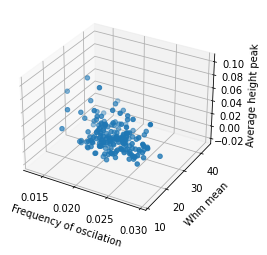

In [ ]:
xdata = frequency_coord
ydata = whm_mean
zdata = h_peaks_coord
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, cmap='Greens');
ax.set_xlabel('Frequency of oscilation')
ax.set_ylabel('Whm mean')
ax.set_zlabel('Average height peak')
plt.show()

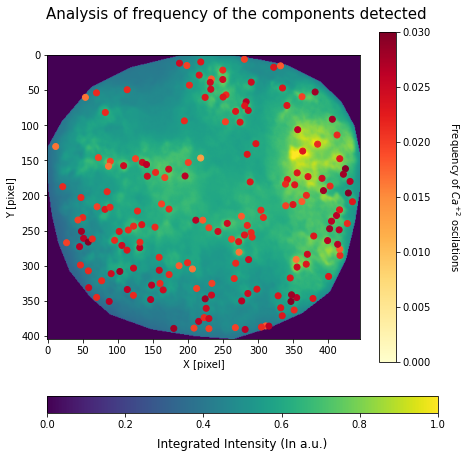

In [ ]:
fig, (ax, cax) = plt.subplots(nrows=2,figsize=(7,7),
                  gridspec_kw={"height_ratios":[1, 0.05]})
### read the image and plot it

median = path_to_model + 'MED_d2_t60_timelapse_mcor.png'
im = plt.imread(median)
implot = ax.imshow(im)

# generate the scatter plot
points = ax.scatter(df['xcoord'],df['ycoord'],c=df['frequency'],cmap='YlOrRd',vmin=0,vmax=0.030)
ax.set_xlabel('X [pixel]')
ax.set_ylabel('Y [pixel]')
# generate the first colorbar
cbar1 = fig.colorbar(points, ax=ax)
cbar1.ax.tick_params(labelsize=10)
cbar1.ax.set_ylabel('Frequency of $Ca^{+2}$ oscilations',rotation = 270)
cbar1.ax.yaxis.set_label_coords(5, 0.5)

# generate the second color bar as a subplt
fig.colorbar(implot, cax=cax, orientation="horizontal")
cax.set_title('Integrated Intensity (In a.u.)',y=-2.5)

fig.suptitle('Analysis of frequency of the components detected',fontsize=15,y=0.93)
plt.savefig('/content/drive/MyDrive/Internship/colabs/Images/yoda1_1um_60min.svg')
plt.show()

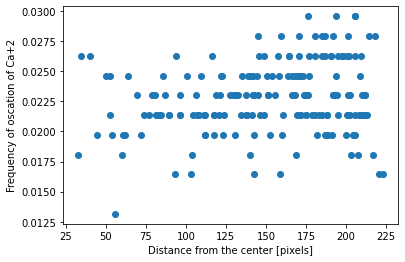

In [ ]:
x_center = im.shape[1]/2
y_center = im.shape[0]/2

def distance_center(x1,y1,x2,y2):
  dist = np.sqrt((x1-x2)**2+(y1-y2)**2)
  return dist
def distance_x(x1,y1,x2,y2):
  dist = np.sqrt((x1-x2)**2)
  return dist
def distance_y(x1,y1,x2,y2):
  dist = np.sqrt((y1-y2)**2)
  return dist
dist_center = [distance_center(xcoord[i],ycoord[i],x_center, y_center) for i in range(len(xcoord))]
dist_x= [distance_x(xcoord[i],ycoord[i],x_center, y_center) for i in range(len(xcoord))]
dist_y = [distance_y(xcoord[i],ycoord[i],x_center, y_center) for i in range(len(xcoord))]

dist_dic = {'dist_center': dist_center,
            'dist_x':dist_x,
            'dist_y':dist_y}

df['dist_center'] = dist_dic['dist_center']
df['dist_x'] = dist_dic['dist_x']
df['dist_y'] = dist_dic['dist_y']
plt.scatter(dist_center, df['frequency'])
plt.xlabel('Distance from the center [pixels]')
plt.ylabel('Frequency of oscation of Ca+2')
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/Internship/colabs/results_df/yoda1_1um_60min.csv')